## Description
        user_id    - unique value for unique user
        timestamp  - user registration date
        test_group - 'a'  control group
                     'b'  alternative group (50% discount)
        conversion - 0 - not converted
                     1 - converted

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

sns.set(style = "whitegrid") # set standard chart style for all notebook

In [3]:
# data set load
df = pd.read_csv('C:/Users/plish/Desktop/Python_HW/AB_test/ab_test_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     19998 non-null  object
 1   timestamp   19998 non-null  object
 2   test_group  19998 non-null  object
 3   conversion  19998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


In [5]:
# number of users in 'a' and 'b' test groups
a_population = df.loc[df['test_group'] == 'a']['user_id'].count()
b_population = df.loc[df['test_group'] == 'b']['user_id'].count()

print(f'Sample size: \n     Control group - A: {a_population} \n    '
                         f' Test group    - B: {b_population}')

Sample size: 
     Control group - A: 10013 
     Test group    - B: 9985


In [6]:
# number of conversions in 'a' and 'b' groups
a_conversions = df.loc[df['test_group'] == 'a']['conversion'].sum()
b_conversions = df.loc[df['test_group'] == 'b']['conversion'].sum()

print(f'Conversions: \n     Control group - A: {a_conversions} \n    '
      f' Test group    - B: {b_conversions}')

Conversions: 
     Control group - A: 611 
     Test group    - B: 889


In [7]:
# conversion rate in 'a' and 'b' groups
cr_a = a_conversions/a_population
cr_b = b_conversions/b_population

print(f'Conversion rates (CR): \n     Control group - A: {cr_a} \n    '
      f' Test group    - B: {cr_b}')

Conversion rates (CR): 
     Control group - A: 0.06102067312493758 
     Test group    - B: 0.08903355032548824


In [8]:
# test start and end dates, test duration
df['date'] = pd.to_datetime(df['timestamp'])
df['date'] = df['date'].dt.date
test_start = df['date'].min()
test_end = df['date'].max()
test_duration = (test_end - test_start).days
print(f'Test start date: {test_start}\nTest end date:   {test_end}\nTest duration:   {test_duration} days')

Test start date: 2023-07-03
Test end date:   2023-07-25
Test duration:   22 days


## Distribution testing

In [9]:
# mean conversion in A and B groups
a_mean = df.loc[df['test_group'] == 'a', 'conversion'].mean() # avg conversion control group A
b_mean = df.loc[df['test_group'] == 'b', 'conversion'].mean() # avg conversion alternative group B
total_mean = df.conversion.mean() # total conversion mean
print(a_mean, b_mean, total_mean)

0.06102067312493758 0.08903355032548824 0.075007500750075


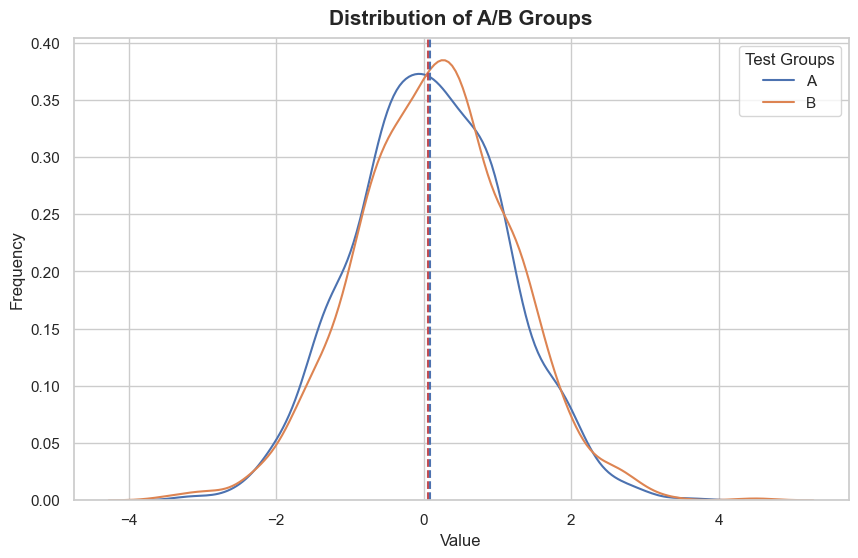

In [10]:
# Distribution of A/B Groups
plt.figure(figsize=(10, 6))

sns.kdeplot(stats.norm.rvs(loc = a_mean, scale = 1, size=1000))
sns.kdeplot(stats.norm.rvs(loc = b_mean, scale = 1, size=1000))

plt.axvline(x=a_mean, color='r', linestyle='--', label= 'A mean')
plt.axvline(x=b_mean, color='b', linestyle='--', label='B mean')

plt.title('Distribution of A/B Groups', fontdict={'fontsize': 15, 'fontweight': 'bold'}, pad = 10)
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.legend(['A', 'B'], title='Test Groups')
plt.show()

In [11]:
control_group = df[df['test_group'] == 'a'] # group A Control
test_group = df[df['test_group'] == 'b'] # group B Alternative

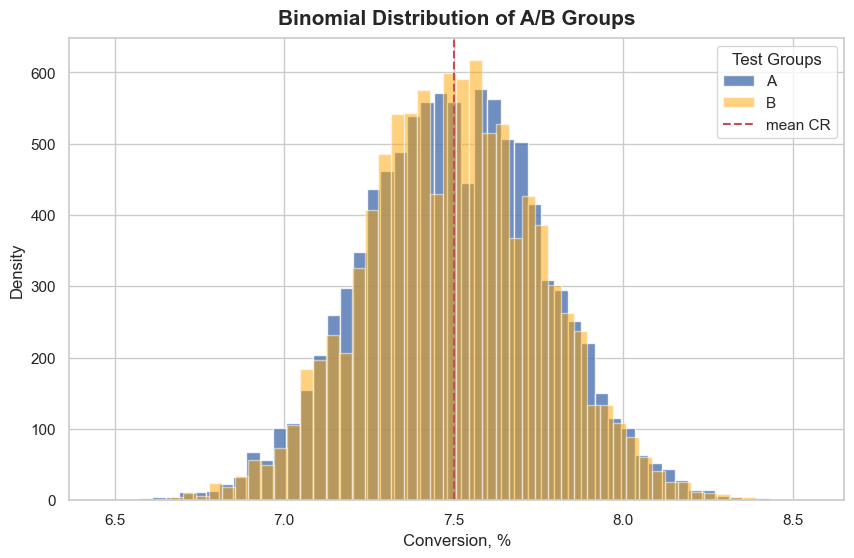

In [12]:
# binomial distribution A and B groups 
plt.figure(figsize=(10, 6))

a_dist = np.random.binomial(len(control_group), total_mean, 10000) / len(control_group) # binomial distribution of A group
b_dist = np.random.binomial(len(test_group), total_mean, 10000) / len(test_group) # binomial distribution of B group

plt.hist(a_dist*100, bins=50, alpha=0.8, label='A')
plt.hist(b_dist*100, bins=50, alpha=0.5, label='B', color='orange')

plt.axvline(x=total_mean*100, color='r', linestyle='--', label= 'mean CR')

plt.title('Binomial Distribution of A/B Groups', fontdict={'fontsize': 15, 'fontweight': 'bold'}, pad = 10)
plt.xlabel('Conversion, %')
plt.ylabel('Density')
plt.legend(title='Test Groups')

plt.show()

## Hypothesys testing

In [13]:
# hypothesis testing using Chi-squared
alpha = 0.05

observed = pd.crosstab(df['test_group'].values, df['conversion'].values) #
statistic, pvalue, dof, expected_values = stats.chi2_contingency(observed)

print(f't-statistic: {round(statistic, 4)}, p-value: {round(pvalue, 4)}')

if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

t-statistic: 56.1425, p-value: 0.0
The difference is statistically significant, Null Hypothesis is rejected.


In [14]:
# hypothesis testing using permutation test to double-check our results
def statistic(x, y):
    return stats.ttest_ind(x, y).statistic

alpha = 0.05

x = df[df['test_group'] == 'a']['conversion']
y = df[df['test_group'] == 'b']['conversion']

results = stats.permutation_test((x, y), statistic, n_resamples=10000)

print(f'statistic: {round(results.statistic, 2)}, p-value: {round(results.pvalue, 2)}')

if results.pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

statistic: -7.53, p-value: 0.0
The difference is statistically significant, Null Hypothesis is rejected.


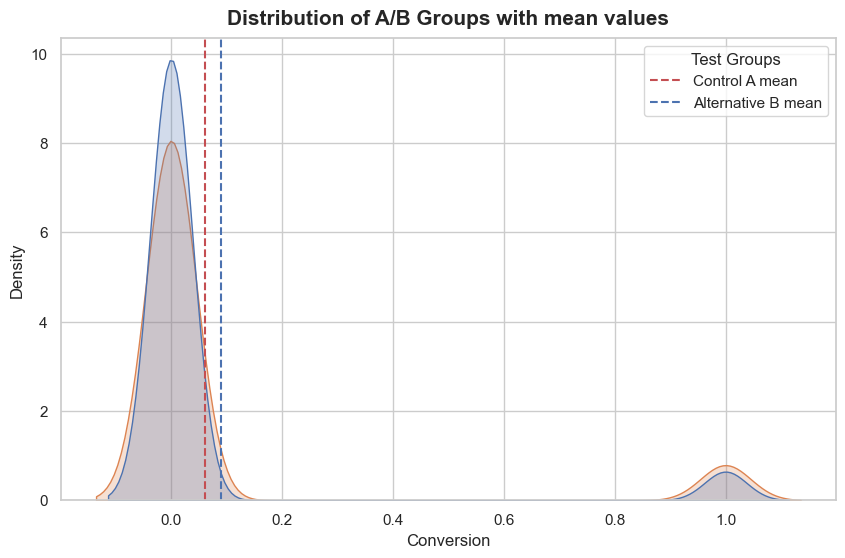

In [15]:
# visualization to compare distribution in groups with mean values
plt.figure(figsize=(10, 6))

sns.kdeplot(data= df, x='conversion', hue='test_group', fill=True, common_norm=False)

plt.axvline(x=a_mean, color='r', linestyle='--', label= 'Control A mean') # mean conversion Group A
plt.axvline(x=b_mean, color='b', linestyle='--', label='Alternative B mean') # mean conversion line Group B

plt.title('Distribution of A/B Groups with mean values', fontdict={'fontsize': 15, 'fontweight': 'bold'}, pad = 10)
plt.xlabel('Conversion')
plt.ylabel('Density')
plt.legend(title = 'Test Groups')

plt.show()

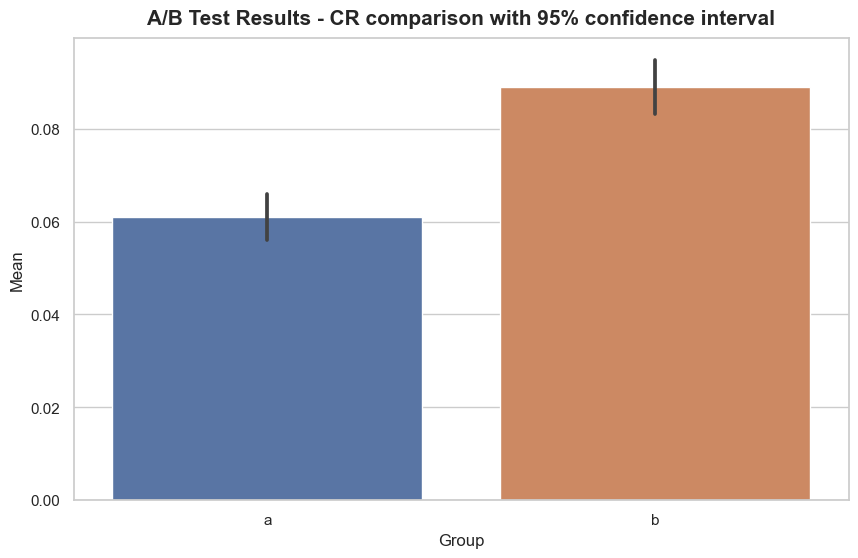

In [16]:
# visualization to compare mean values in groups with 95% confidence interval
plt.figure(figsize=(10, 6))
sns.barplot(x=df['test_group'],
            y=df['conversion'],
            errorbar=('ci', 95)) # Confidence Intervals

plt.title('A/B Test Results - CR comparison with 95% confidence interval', fontdict={'fontsize': 15, 'fontweight': 'bold'}, pad = 10)
plt.xlabel('Group')
plt.ylabel('Mean')

plt.show()

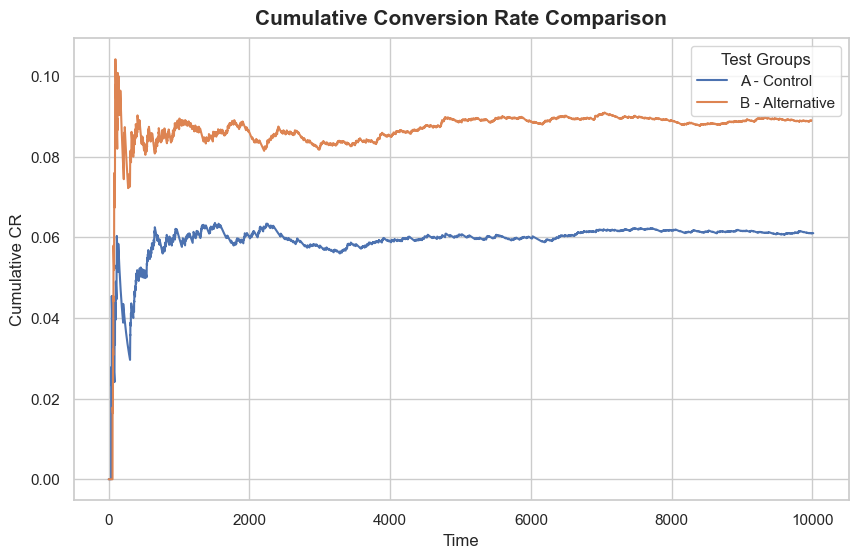

In [17]:
# Cumulative conversion rate change over time
df['timestamp'] = pd.to_datetime(df['timestamp']) # change column type from string to datetime
df = df.sort_values(by='timestamp', ascending=True) # sort dates accending

# calculation of cumulative mean - it is CR change over time
cumulative_metric_a = df[df['test_group'] == 'a']['conversion'].expanding().mean().reset_index(drop=True)
cumulative_metric_b = df[df['test_group'] == 'b']['conversion'].expanding().mean().reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_metric_a, label='A - Control')
plt.plot(cumulative_metric_b, label='B - Alternative')

plt.title('Cumulative Сonversion Rate Comparison', fontdict={'fontsize': 15, 'fontweight': 'bold'}, pad = 10)
plt.xlabel('Time')
plt.ylabel('Cumulative СR')

plt.legend(title = 'Test Groups')

plt.show()

In [18]:
# Create a pivot table to compare metrics
pivot_table = pd.pivot_table(df, values='user_id', index='test_group', columns='conversion', aggfunc='count', fill_value=0)

# Calculate the conversion rate
pivot_table['Conversion Rate'] = round(pivot_table[1] / (pivot_table[0] + pivot_table[1]), 4)
pivot_table[0] = pivot_table[0] + pivot_table[1]
# Rename the columns
pivot_table.columns = ['Total Users', 'Converted', 'Conversion Rate']
pivot_table.index = ['Group A', 'Group B']
# Display the table
print(pivot_table)

         Total Users  Converted  Conversion Rate
Group A        10013        611            0.061
Group B         9985        889            0.089
